# Training a NN 

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Problem
Lets try to predict commute duration from two observable independent variables: time of day, and weather.

<IPython.core.display.Javascript object>


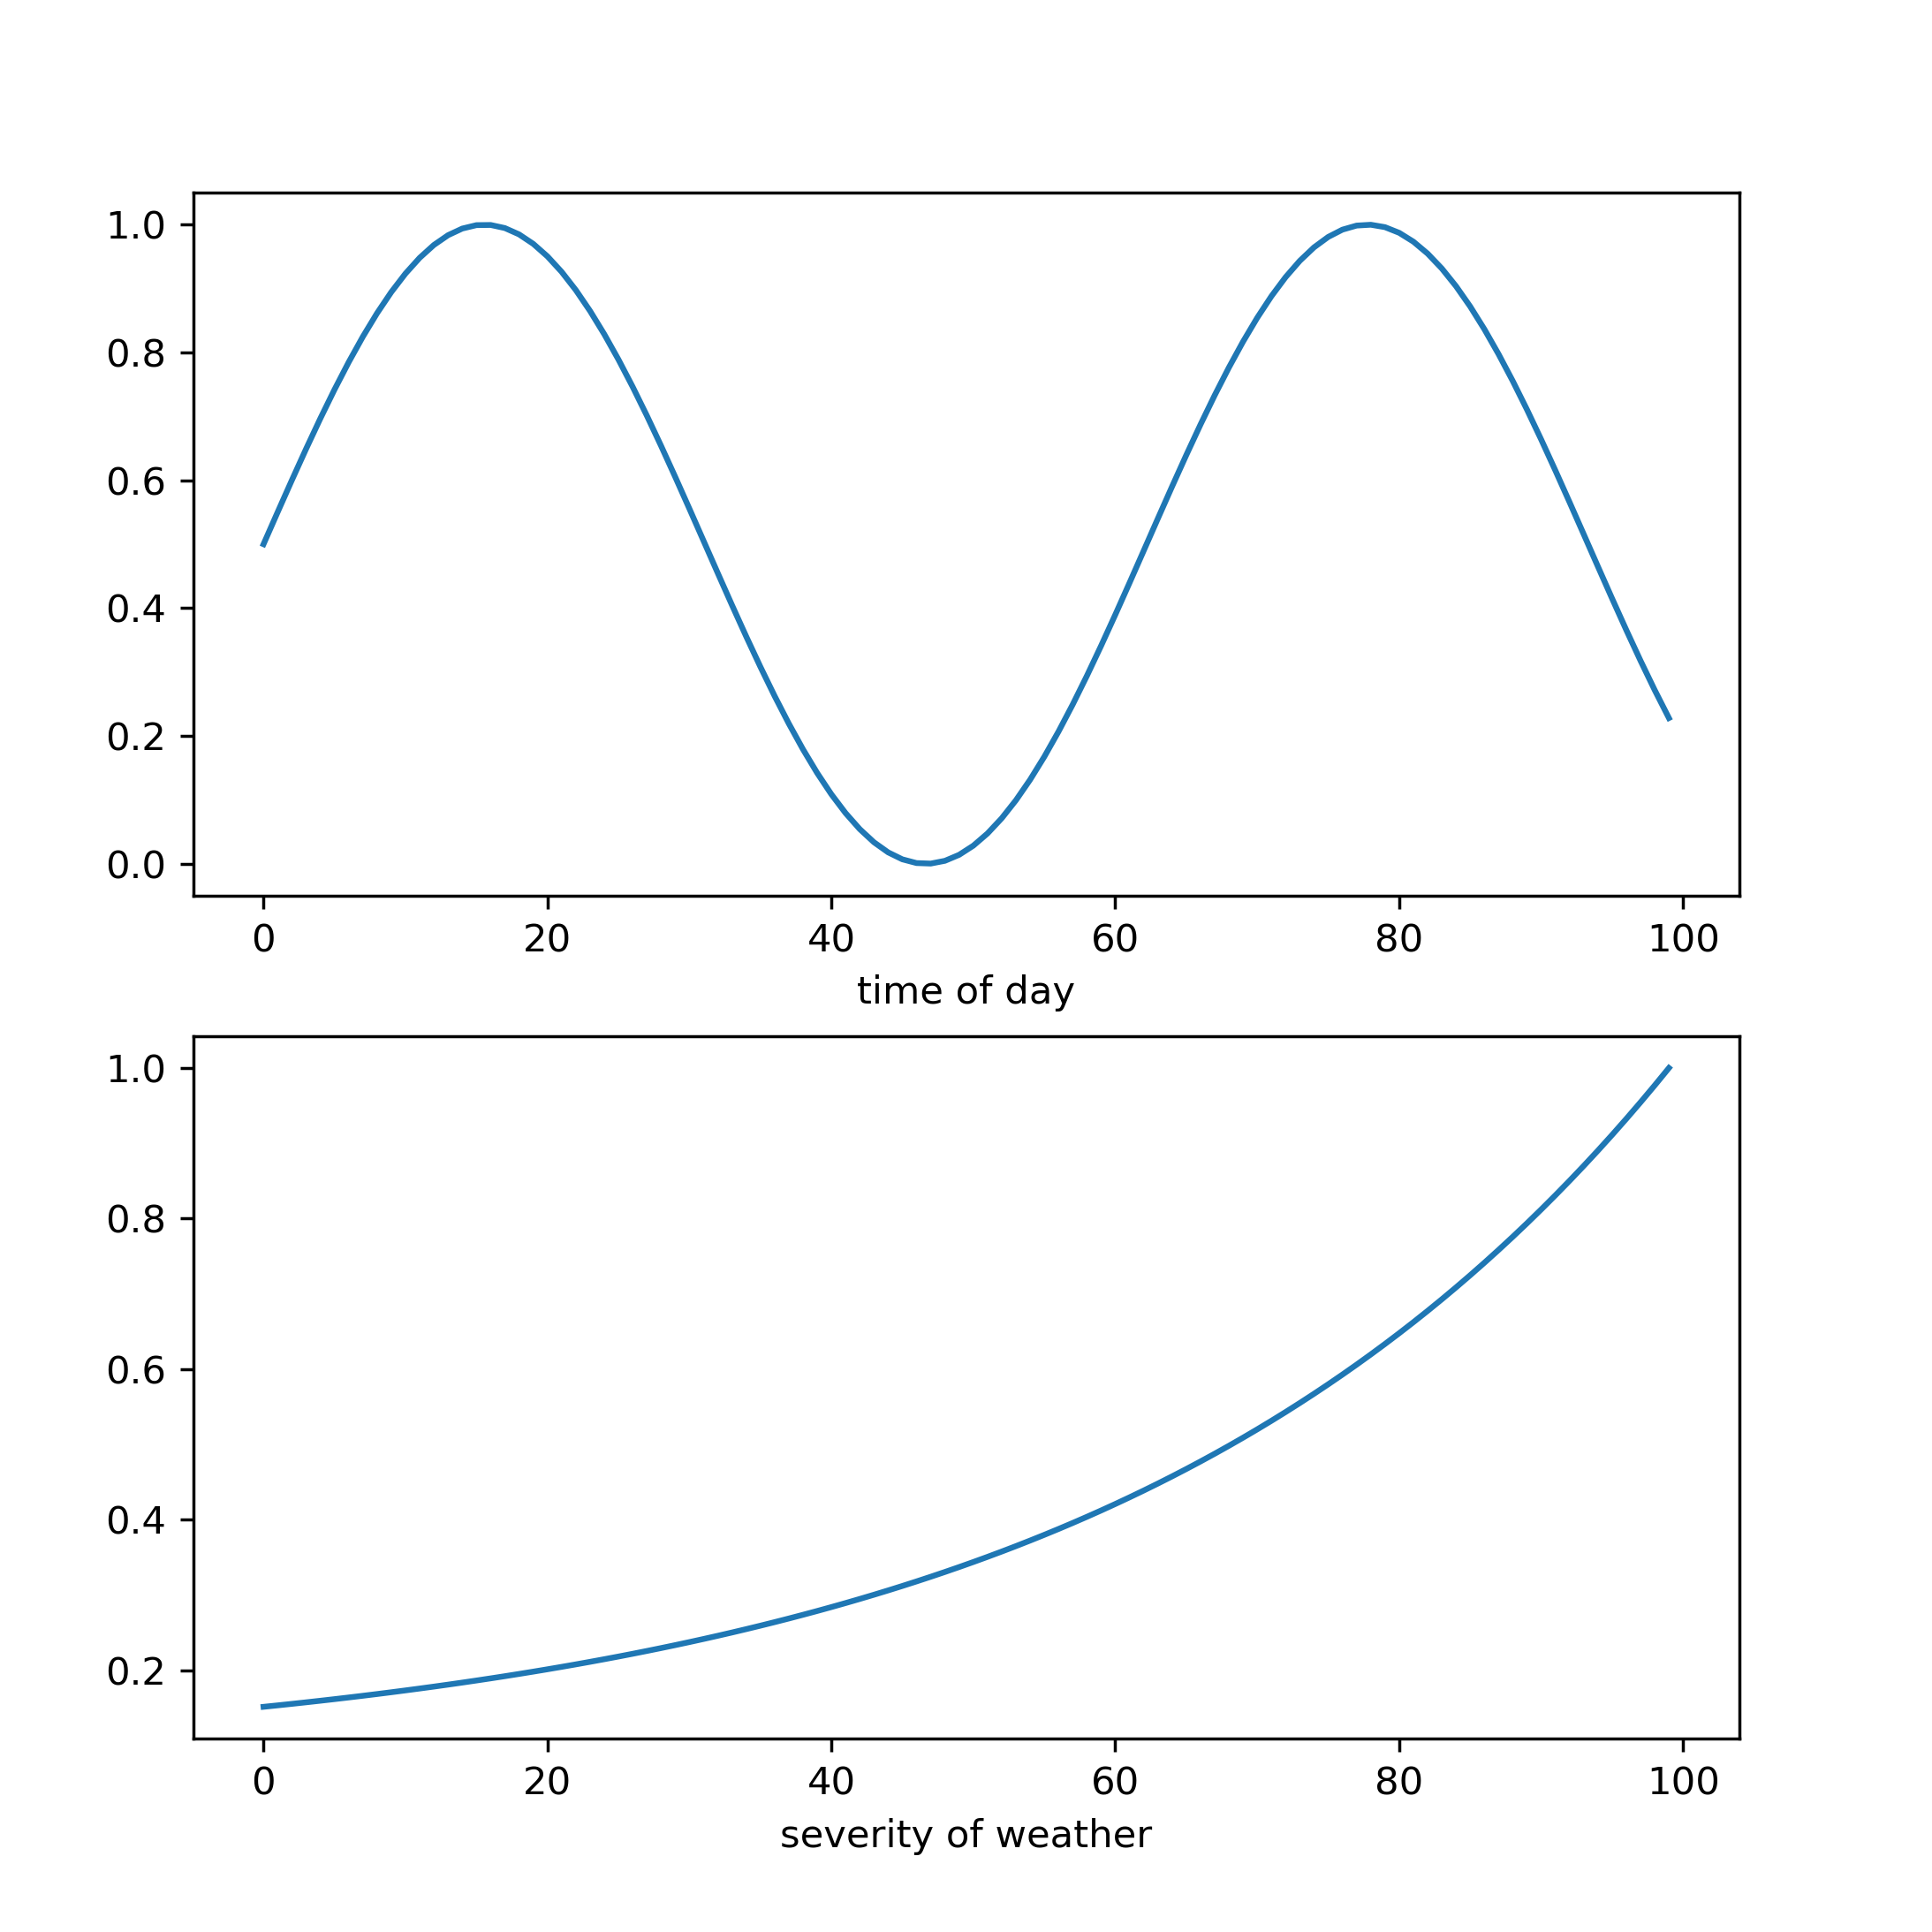

<IPython.core.display.Javascript object>


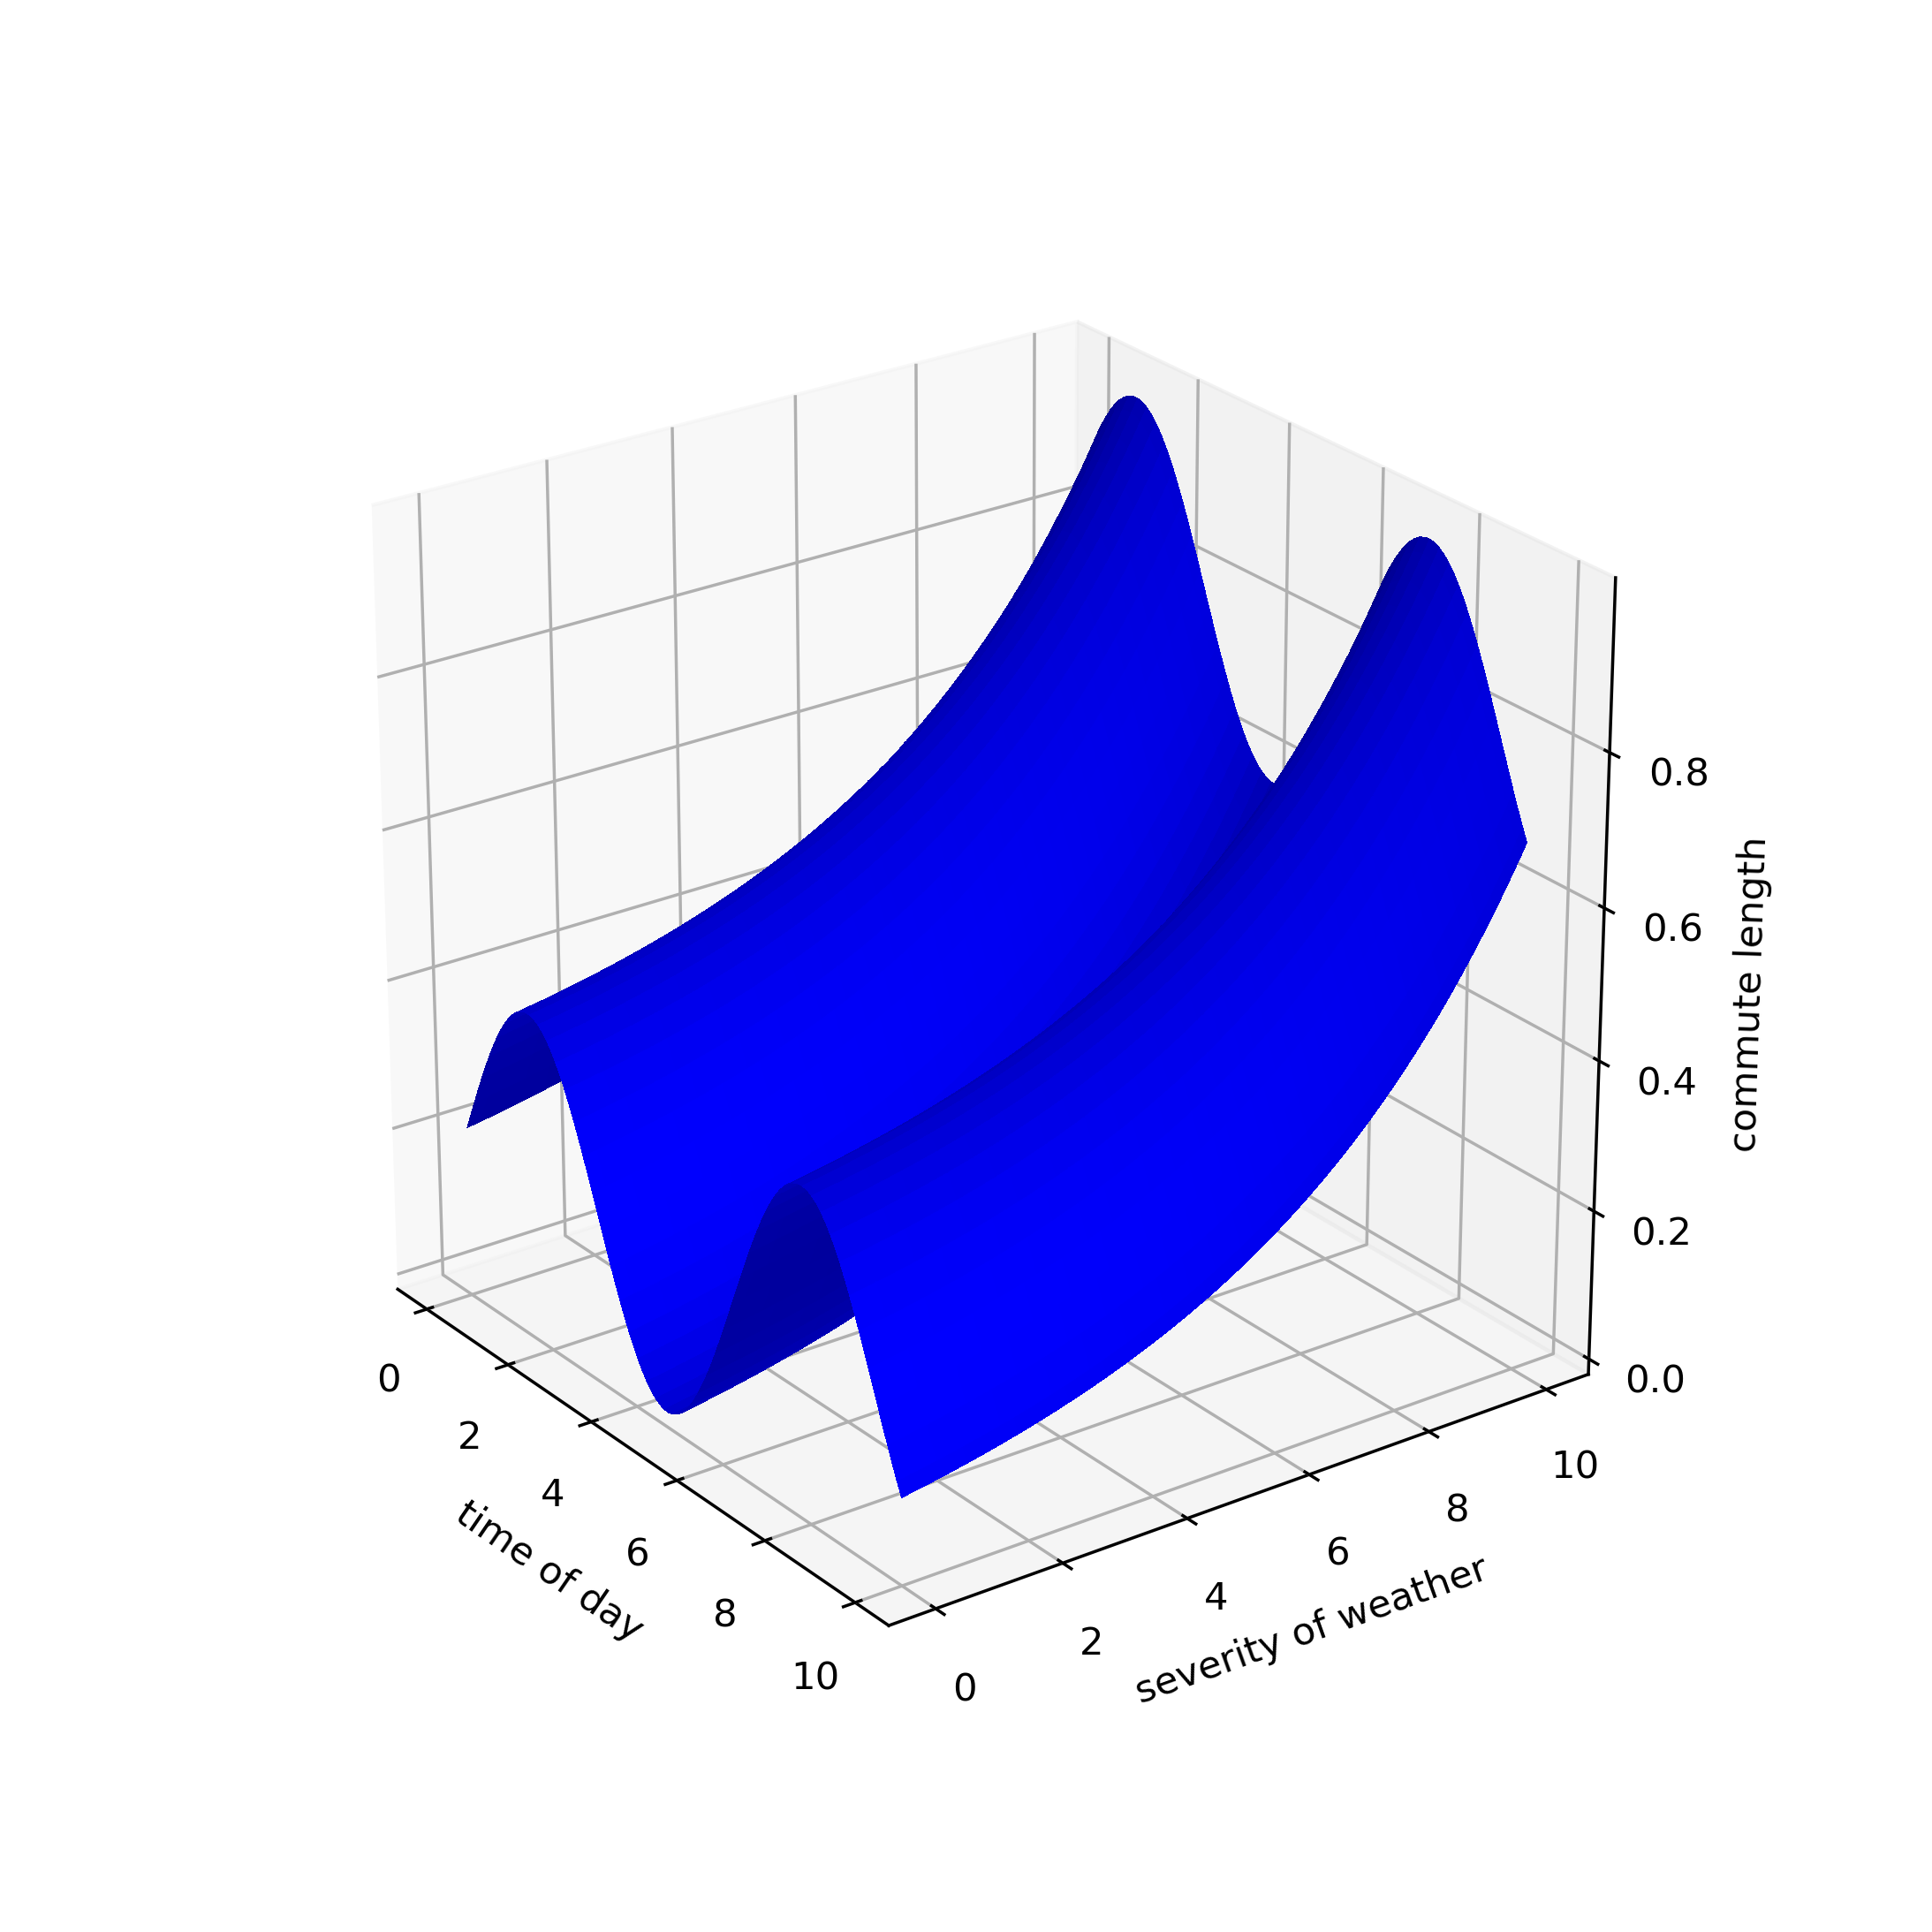

In [3]:
# define data coordinates
xRange = [0,10]; 
yRange = [0,10]; numSteps = 100

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x
    
# define 1D relationships to target
xComponent = np.sin( x ) * 4
yComponent = np.exp( y / 4 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)

# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time of day')
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('severity of weather')

# plot target [dependent] variable
plt.figure( figsize = (7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()


# Generate the Dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [4]:
NSamples = 4000
noiseScaling = 1/8.

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

trainData = np.zeros( ( NSamples, 2 ) )
targetValues = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    trainData[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    trainData[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    targetValues[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]


In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import metrics
import keras

model = Sequential()
model.add( Dense( 5, input_dim = 2 ))
model.add( Dense( 15, activation='sigmoid' ))
model.add( Dense( 15, activation='sigmoid' ))
model.add( Dense( 15, activation='sigmoid' ))
model.add( Dense( 15, activation='sigmoid' ))
model.add( Dense( 1, activation='linear' ))

model.compile(optimizer='adam', loss='mse')

# Visualize the Network

<IPython.core.display.Javascript object>


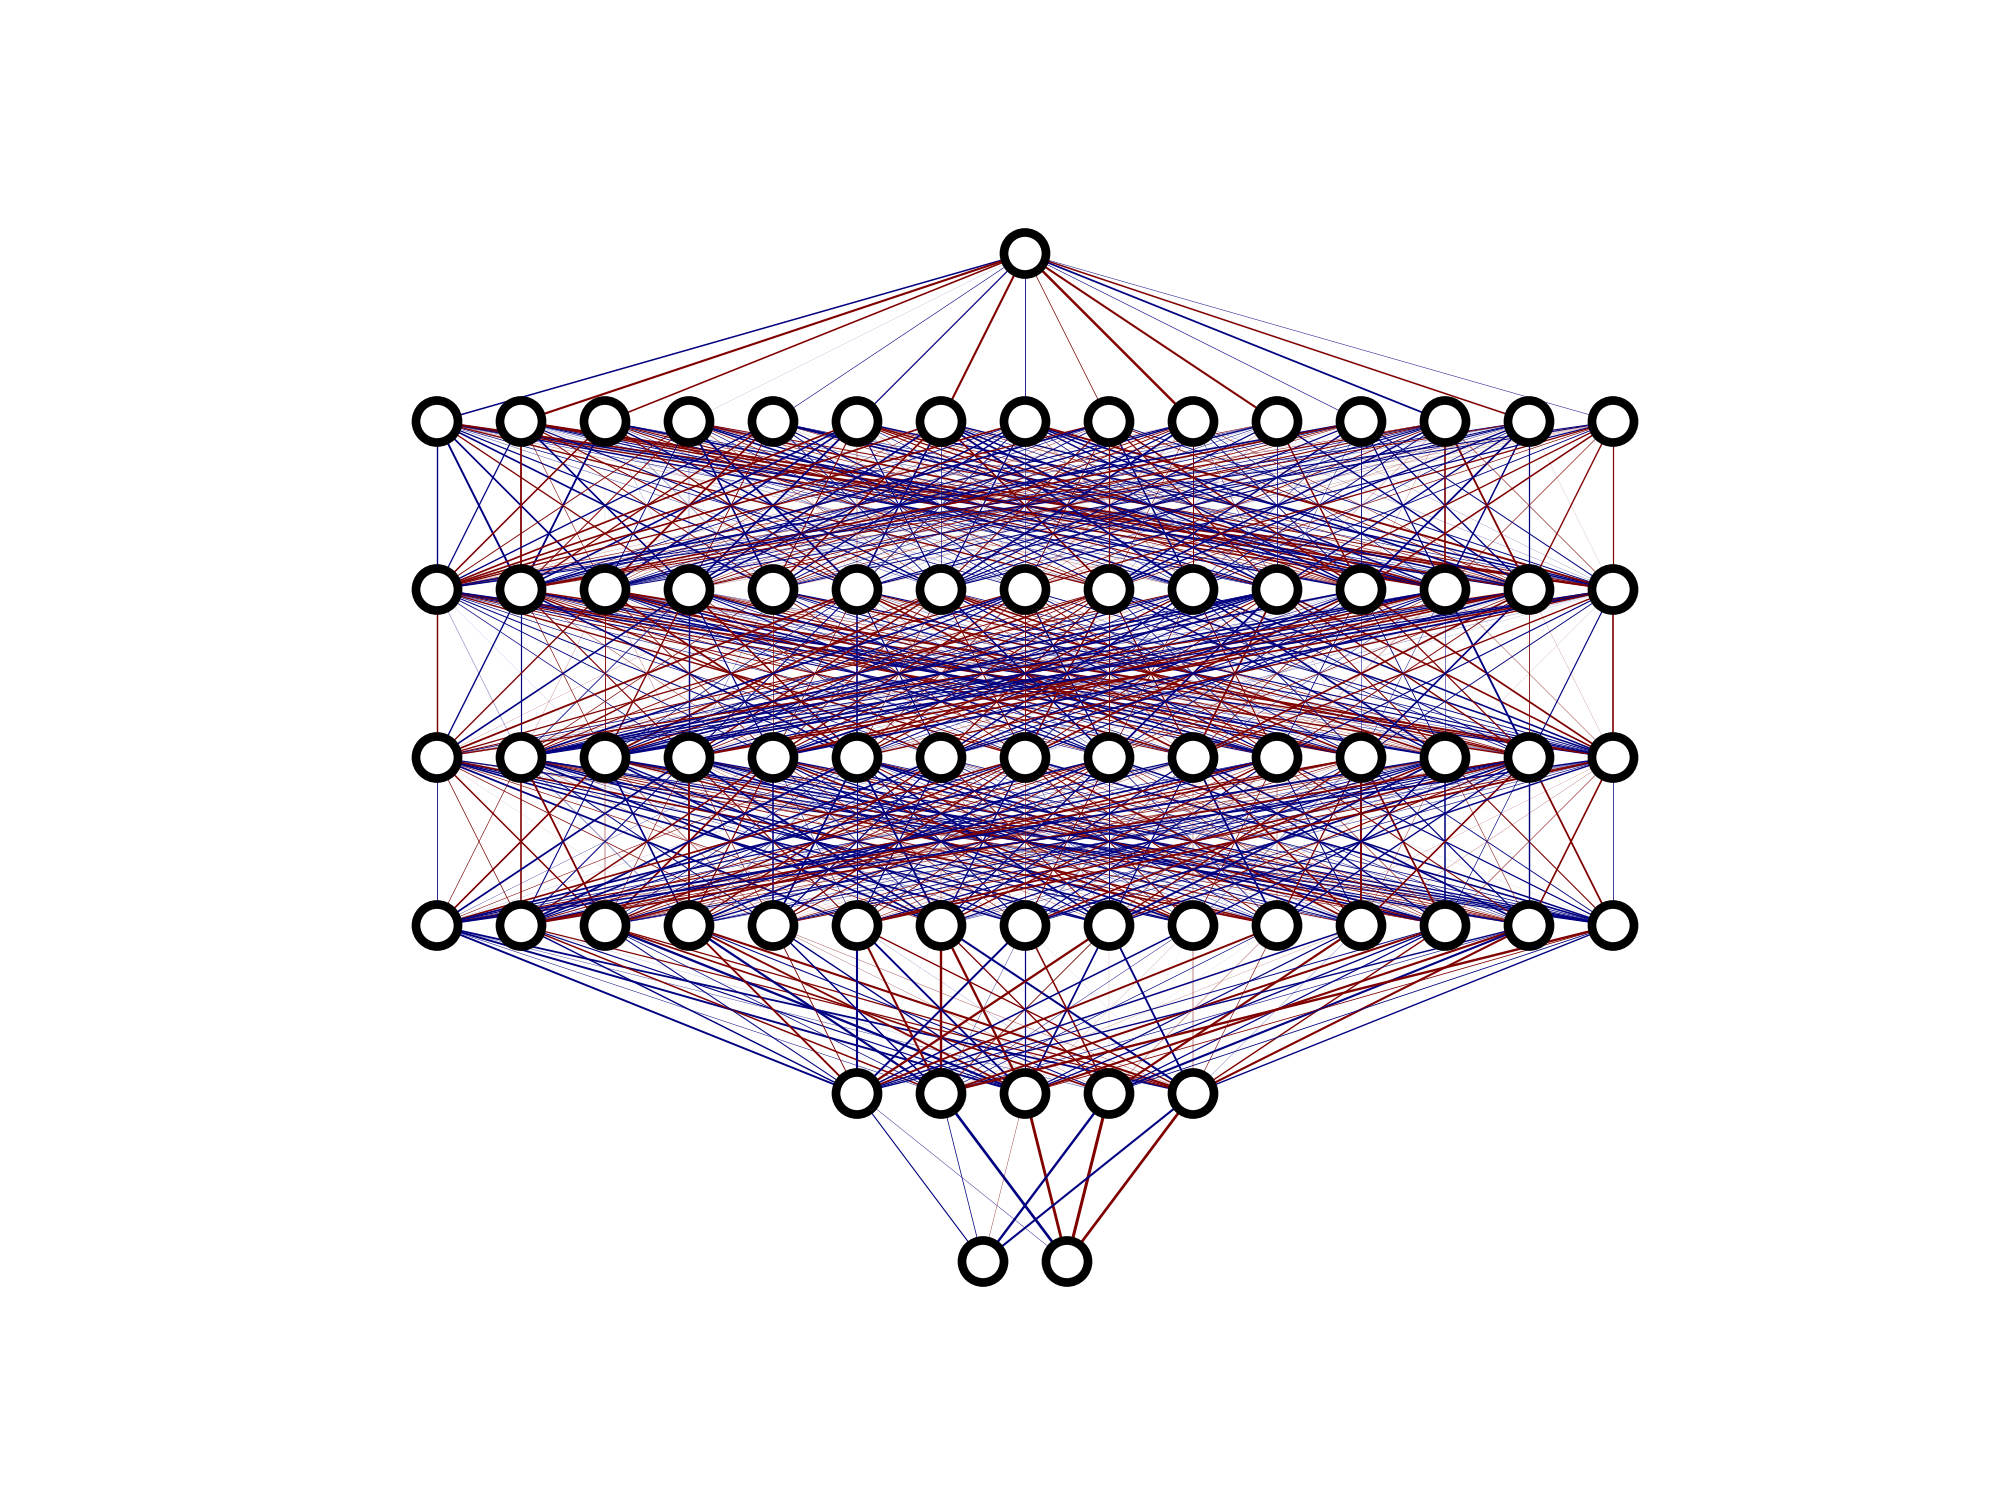

In [39]:
plt.figure()
import nnViz
nnViz.visualize_model(model)

In [40]:
from k3d import K3D

NEpochs = 300
displayUpdateInterval = 10

plot = K3D()
zScaling = 5

offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                      np.ones((trainData.shape[0], 1)) + 4, 
                      np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

plot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ) + offset, color=0xFF0000, point_size = .2, shader = 'flat' )
plot += K3D.surface ( z*zScaling, color=0x00FF00, xmin=np.min(trainData[:,0]+offset[::,0]), xmax=np.max(trainData[:,0]+offset[::,0]), ymin=np.min(trainData[:,1]+offset[::,1]), ymax=np.max(trainData[:,1]+offset[::,1]))
plot.display()

In [41]:
currentNN = {}

xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1)) 
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0


evalLoss = np.empty((NEpochs))
evalLoss[:] = np.NaN

for iEpoch in range(NEpochs):
    
    model.fit ( trainData, targetValues, 
               epochs = 1, 
               batch_size = 128, 
               verbose = 0, 
               shuffle = True ) #, callbacks = [earlyStopping], validation_split = 0.25, shuffle = True )

     
    evalLoss[iEpoch] = model.evaluate( trainData, targetValues )

    if iEpoch % displayUpdateInterval == 0:
        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        
        currentNN[plotCount] = model.predict( trainData )
        
        print('\n current error: ' + str( evalLoss[plotCount]) )
        plot += K3D.points ( np.hstack( ( trainData, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        plot += K3D.text2d ( str( round(evalLoss[plotCount], 4 )), comboOffset + offset + (0, 0, 3), color=0xff00ff, size=.5, reference_point='rb')
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

3360/4000 [========================>.....] - ETA: 0s
 current error: 0.460888776064
3968/4000 [============================>.] - ETA: 0s
 current error: 0.0883226012588
3680/4000 [==========================>...] - ETA: 0s
 current error: 0.0471787206233
3808/4000 [===========================>..] - ETA: 0s
 current error: 0.0463741316497
3872/4000 [============================>.] - ETA: 0s
 current error: 0.045824296996
3680/4000 [==========================>...] - ETA: 0s
 current error: 0.0452179708481
3648/4000 [==========================>...] - ETA: 0s
 current error: 0.0445202190876
3648/4000 [==========================>...] - ETA: 0s
 current error: 0.0436917898059
3360/4000 [========================>.....] - ETA: 0s
 current error: 0.042716114074
3584/4000 [=========================>....] - ETA: 0s
 current error: 0.0415700176656
3424/4000 [========================>.....] - ETA: 0s
 current error: 0.040281817019
3520/4000 [=========================>....] - ETA: 0s
 current error: 

<IPython.core.display.Javascript object>


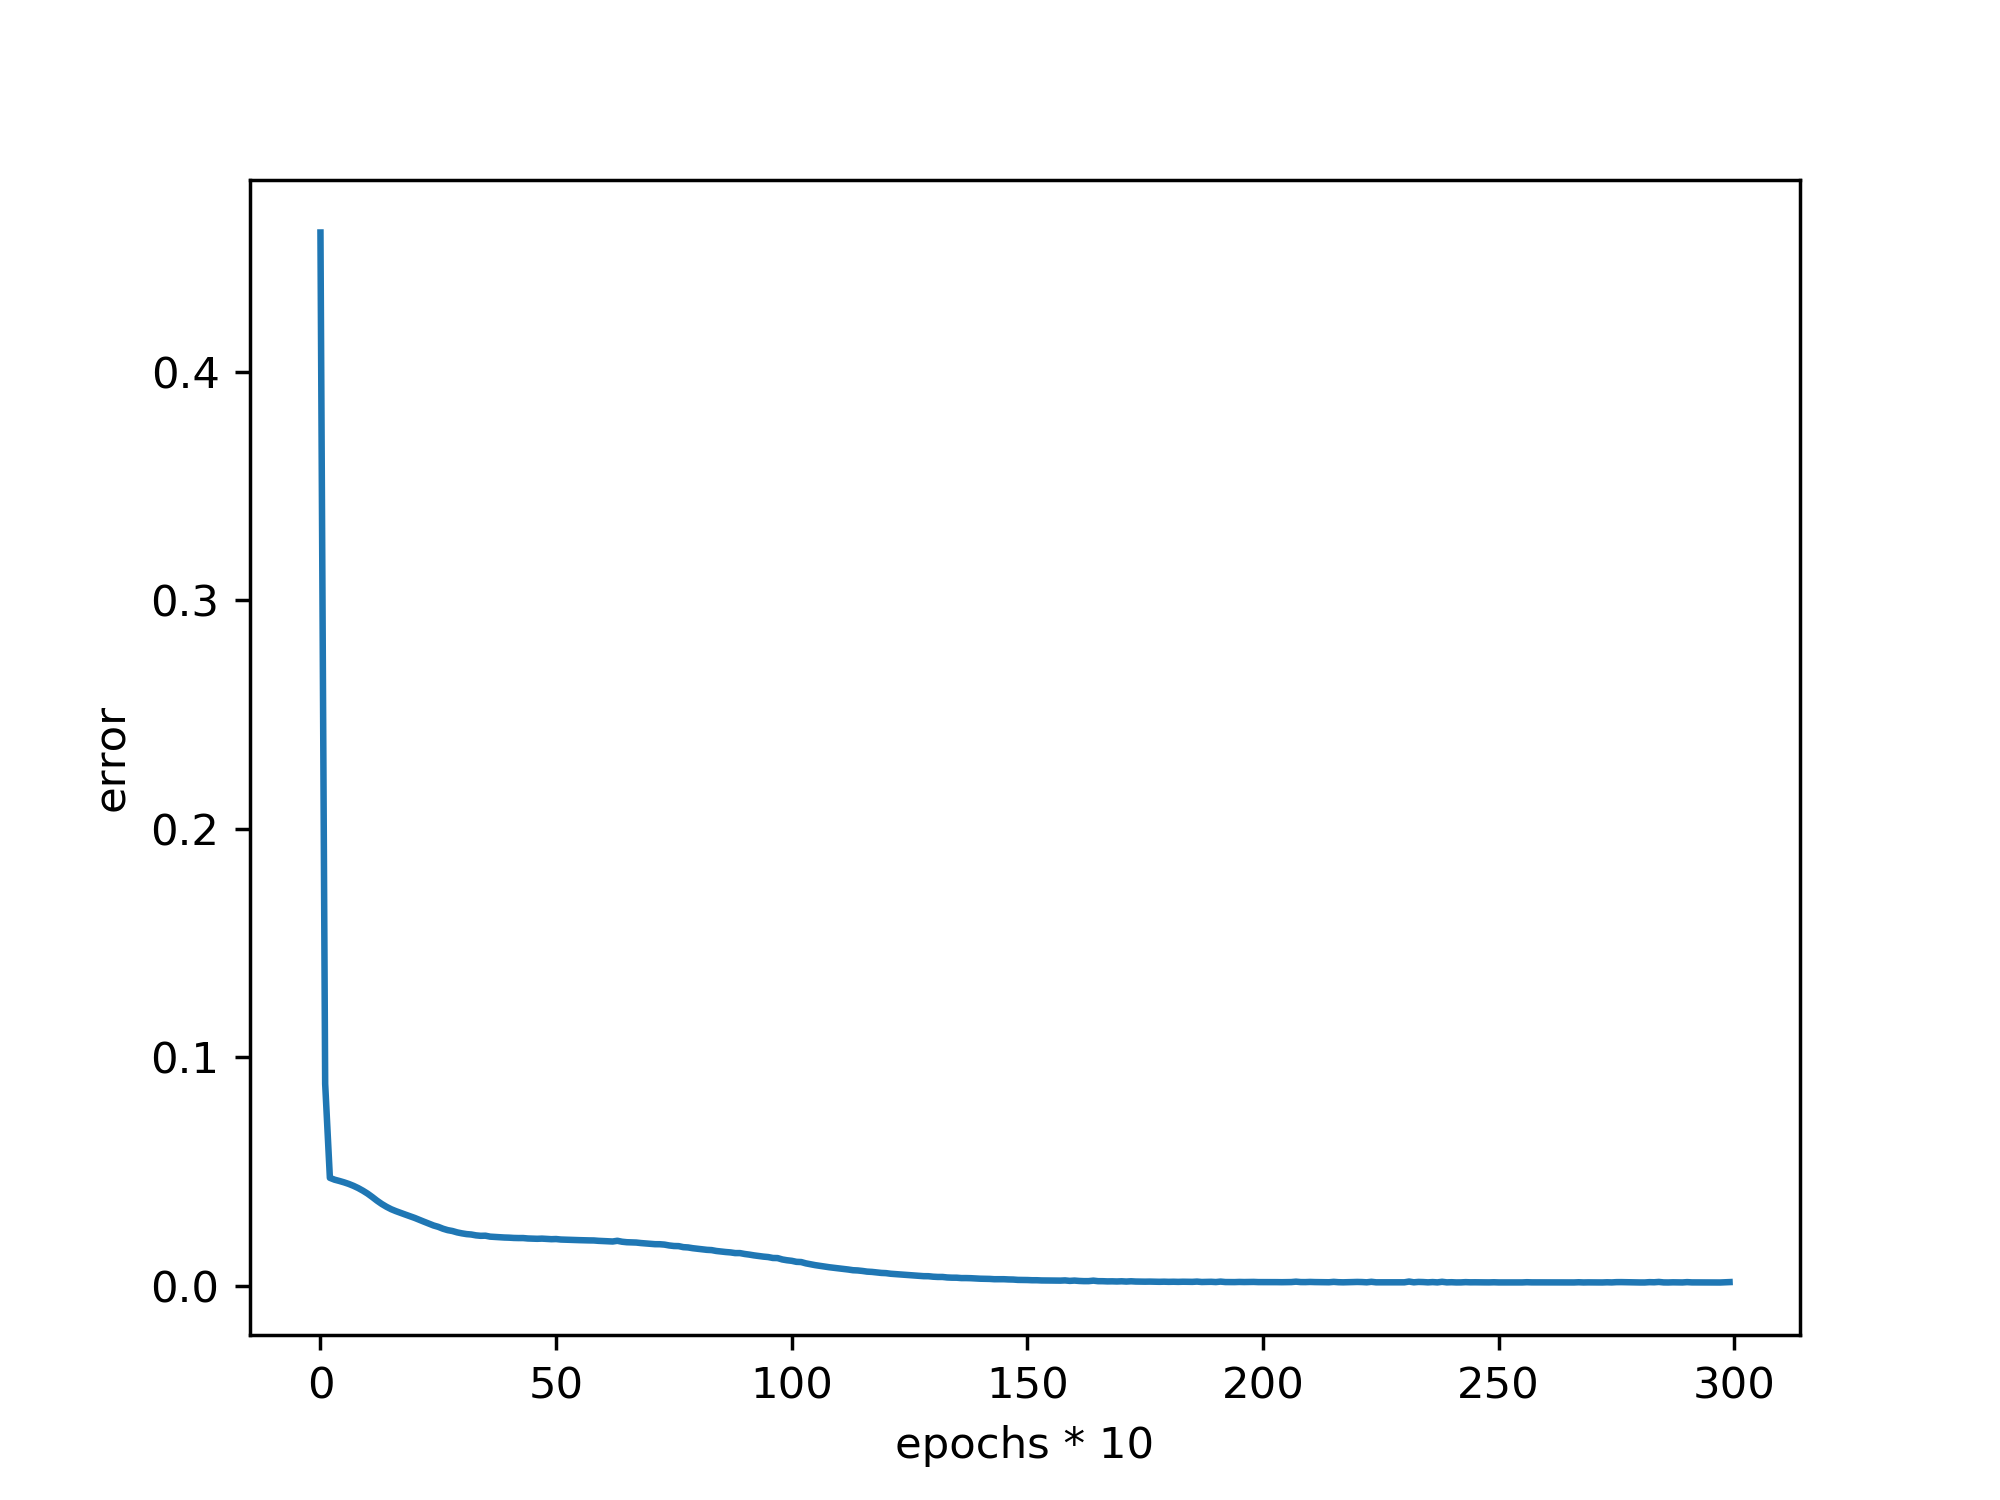

In [42]:
plt.figure()
plt.plot(evalLoss[:])
plt.xlabel('epochs * ' + str(displayUpdateInterval))
plt.ylabel('error')
#evalLoss

In [43]:
plot = K3D()
plot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( trainData, currentNN[0]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x00FF00, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

In [48]:
plot = K3D()
plot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( trainData, currentNN[int(plotCount/2.5)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x00FF00, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

In [46]:
plot = K3D()
plot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( trainData, currentNN[plotCount-1]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x00FF00, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

In [ ]:
plt.figure()
import nnViz
nnViz.visualize_model(model)